# Prompting Language Models

In ths notebook, we'll be evaluating different model prompting strategies on a publicly available language model. We will then perform soft-prompt tuning on GPT-2 and compare it against hard prompting.

## Install required packages

In [ ]:
!pip install transformers
!pip install inflect
!pip install cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.4 MB/s eta 0:00:00


In [ ]:
import pickle as pkl
import os
import json
# import cohere
import random
import inflect
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
import time
from collections import deque

random.seed(0)
np.random.seed(0)

# Load the dataset

We will be using the Common Sense QA dataset, which is a collection of questions about everyday life. The cells below download the data from https://www.tau-nlp.sites.tau.ac.il/commonsenseqa .

In [ ]:
# Load dataset from jsonl file
def make_dataset(path):
    dataset = []
    with open(path) as f:
        for line in f:
            dataset.append(json.loads(line))
    return dataset

In [ ]:
#@title download the dataset
!curl https://s3.amazonaws.com/commensenseqa/train_rand_split.jsonl -o train_rand_split.jsonl
!curl https://s3.amazonaws.com/commensenseqa/dev_rand_split.jsonl -o dev_rand_split.jsonl
!curl https://s3.amazonaws.com/commensenseqa/test_rand_split_no_answers.jsonl -o test_rand_split_no_answers.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3697k  100 3697k    0     0  4594k      0 --:--:-- --:--:-- --:--:-- 4598k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  460k  100  460k    0     0   803k      0 --:--:-- --:--:-- --:--:--  803k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  413k  100  413k    0     0   727k      0 --:--:-- --:--:-- --:--:--  727k


In [ ]:
train_set = make_dataset('train_rand_split.jsonl')
val_set = make_dataset('dev_rand_split.jsonl')

# Print the lengths of the train and validation sets
print(len(train_set), len(val_set))

9741 1221


Here are a few examples of the dataset format:

In [ ]:
val_set[:3]

[{'answerKey': 'A',
  'id': '1afa02df02c908a558b4036e80242fac',
  'question': {'question_concept': 'revolving door',
   'choices': [{'label': 'A', 'text': 'bank'},
    {'label': 'B', 'text': 'library'},
    {'label': 'C', 'text': 'department store'},
    {'label': 'D', 'text': 'mall'},
    {'label': 'E', 'text': 'new york'}],
   'stem': 'A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?'}},
 {'answerKey': 'A',
  'id': 'a7ab086045575bb497933726e4e6ad28',
  'question': {'question_concept': 'people',
   'choices': [{'label': 'A', 'text': 'complete job'},
    {'label': 'B', 'text': 'learn from each other'},
    {'label': 'C', 'text': 'kill animals'},
    {'label': 'D', 'text': 'wear hats'},
    {'label': 'E', 'text': 'talk to each other'}],
   'stem': 'What do people aim to do at work?'}},
 {'answerKey': 'B',
  'id': 'b8c0a4703079cf661d7261a60a1bcbff',
  'question': {'question_concept': 'magazines',
   'choices': [{'label': 'A', 't

In [ ]:
def make_simple_prompt(data_point):
    prompt = f"""{data_point['question']['stem']}
 {data_point['question']['choices'][0]['label']} {data_point['question']['choices'][0]['text']}
 {data_point['question']['choices'][1]['label']} {data_point['question']['choices'][1]['text']}
 {data_point['question']['choices'][2]['label']} {data_point['question']['choices'][2]['text']}
 {data_point['question']['choices'][3]['label']} {data_point['question']['choices'][3]['text']}
 {data_point['question']['choices'][4]['label']} {data_point['question']['choices'][4]['text']}
"""
    return prompt

def make_simple_qa_prompt(data_point):
    prompt = f"""Question: {data_point['question']['stem']}
Choice {data_point['question']['choices'][0]['label']}: {data_point['question']['choices'][0]['text']}
Choice {data_point['question']['choices'][1]['label']}: {data_point['question']['choices'][1]['text']}
Choice {data_point['question']['choices'][2]['label']}: {data_point['question']['choices'][2]['text']}
Choice {data_point['question']['choices'][3]['label']}: {data_point['question']['choices'][3]['text']}
Choice {data_point['question']['choices'][4]['label']}: {data_point['question']['choices'][4]['text']}
Answer:"""
    return prompt

def get_instruction():
    return "Answer the following question with A, B, C, D, or E.\n"

def make_qa_instruction_prompt(data_point):
    prompt = get_instruction()
    prompt += make_simple_qa_prompt(data_point)
    return prompt

def make_few_shot_prompt(data_point, num_shots):
    prompt = get_instruction()
    for i in range(num_shots):
        prompt += make_simple_qa_prompt(train_set[i])
        prompt += f" {train_set[i]['answerKey']}\n"
    prompt += make_simple_qa_prompt(data_point)
    return prompt

# This is like the prompt above, but the answers in the examples given are random, not the correct answer
def make_incorrect_few_shot_prompt(data_point, num_shots):
    prompt = get_instruction()
    for i in range(num_shots):
        prompt += make_simple_prompt(train_set[i])
        valid_answers = ['A', 'B', 'C', 'D', 'E']
        valid_answers.remove(train_set[i]['answerKey'])
        # Randomly choose an incorrect answer
        random_answer = random.choice(valid_answers)
        prompt += f"{random_answer}\n"
    prompt += make_simple_qa_prompt(data_point)
    return prompt

In [ ]:
# Printing the log probs for the generated tokens
prompt_strategies = {
    # 'simple': make_simple_prompt, # removed since it's always incorrect
    'simple_qa': make_simple_qa_prompt,
    'qa_instruction': make_qa_instruction_prompt,
    'few_shot': lambda x: make_few_shot_prompt(x, num_shots),
    'incorrect_few_shot': lambda x: make_incorrect_few_shot_prompt(x, num_shots)
}

# Training GPT-2 for soft prompt tuning

GPT-2 is the smaller predecessor model to GPT-3. We will use GPT-2 for soft prompt tuning as it is
publicly available(unlike GPT-3) and small enough to train on the free version of the colab GPU
(unlike GPT-J).

Soft prompt tuning is described in this [paper](https://arxiv.org/abs/2104.08691v1), which we encourage you to learn more about. In essence, instead of generating answers by putting in token prompts, we use fine tuning to train the embeddings of new learned tokens. This allows us to generate answers by putting in the new learned tokens instead of tokens which correspond to real words.

Most of the code has been implemented for you, but you should still read through the code to understand what it's doing. There is one TODO which asks you to set up the optimizer. Think about which parameters should get passed into the optimizer.


In [ ]:
#@title Define soft embedding for GPT-2
class SoftEmbedding(nn.Module):
    def __init__(self,
                wte: nn.Embedding,
                n_tokens: int = 10,
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        """
        Here, we concatentate a new task-specific learned embedding to the existing GPT-2 embedding.
        Args:
            wte (nn.Embedding): original transformer word embedding
            n_tokens (int, optional): number of tokens for task. Defaults to 10.
            random_range (float, optional): range to init embedding (if not initialize from vocab). Defaults to 0.5.
            initialize_from_vocab (bool, optional): initalizes from default vocab. Defaults to True.
        """
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                               n_tokens,
                                                                               random_range,
                                                                               initialize_from_vocab))

    def initialize_embedding(self,
                             wte: nn.Embedding,
                             n_tokens: int = 10,
                             random_range: float = 0.5,
                             initialize_from_vocab: bool = True):
        """initializes learned embedding
        Args:
            same as __init__
        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)

    def forward(self, tokens):
        """run forward pass
        Args:
            tokens (torch.long): input tokens before encoding
        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        # The first n_tokens embeddings are reserved for the learned embeddings
        # The rest of the embeddings are the original GPT-2 embeddings
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", padding_side='left')
tokenizer.pad_token=tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_tokens = 100

def initialize_soft_model():
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    initialize_from_vocab = True

    # Set the input embeddings to the GPT2 model
    s_wte = SoftEmbedding(model.get_input_embeddings(),
                        n_tokens=n_tokens,
                        initialize_from_vocab=initialize_from_vocab)
    model.set_input_embeddings(s_wte)
    model.to(device)
    return model

# While we didn't need to do this for GPT-3 earlier, training the model means we need to turn the text
# into tokens that the model can understand via the embedding layer.
def process_dataset(dataset, mapper_fn, pad_length=119):
    mapped_dataset = [mapper_fn(item) for item in dataset]
    if pad_length is None:
        out = tokenizer(mapped_dataset, return_tensors='pt', padding=True)
    else:
        out = tokenizer(mapped_dataset, return_tensors='pt', padding="max_length", max_length=pad_length)
    # Need to add a space as GPT differentiates between " A" and "A" and it will be predicting " A".
    answerkey = [' ' + item['answerKey'] for item in dataset]
    out['answerkey'] = tokenizer(answerkey, return_tensors='pt', max_length=1)['input_ids']
    return out

def pad_soft_inputs(inputs):
    """
    We need to pad the attention_mask and input_ids with an extra n_learned_tokens
    It does not matter what you pad input_ids with since these will be overwritten by learned embeddings
    """
    batch = len(inputs['input_ids'])
    inputs['input_ids'] = torch.cat([torch.full((batch, n_tokens), 50256).to(device), inputs['input_ids'].to(device)], 1).to(device)
    inputs['attention_mask'] = torch.cat([torch.full((batch, n_tokens), 1).to(device), inputs['attention_mask'].to(device)], 1).to(device)
    return inputs

# Train the model
def train_model(model, train_set, val_set, dataset_processor, batch_size=8, epochs=1, lr=1e-4, print_every=100):
    train_dataset = process_dataset(train_set, dataset_processor)
    val_dataset = process_dataset(val_set, dataset_processor)
    parameters_to_train = [model.get_input_embeddings().learned_embedding]
    optimizer = torch.optim.Adam(parameters_to_train, lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    epoch_train_losses = []
    for i in range(epochs):
        epoch_loss = 0
        for j in range(0, len(train_dataset['input_ids']), batch_size):
            # Calculate cross entropy loss between predicted last token and actual last token
            optimizer.zero_grad()
            inputs = {k: v[j:j+batch_size].to(device) for k, v in train_dataset.items()}
            inputs = pad_soft_inputs(inputs)
            labels = inputs.pop('answerkey')
            outputs = model(**inputs).logits[:, -1, :] # (batch_size, vocab_size)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            # loss calculated by criterion is averaged over batch, so multiply by batch size to get total loss
            epoch_loss += loss.item() * labels.shape[0]
            if j % print_every == 0:
                print(f'Epoch {i}, Item {j}, loss: {loss.item()}')
        epoch_loss /= train_dataset['input_ids'].shape[0]
        epoch_train_losses.append(epoch_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        for j in range(0, len(val_dataset['input_ids']), batch_size):
            inputs = {k: v[j:j+batch_size].to(device) for k, v in val_dataset.items()}
            inputs = pad_soft_inputs(inputs)
            labels = inputs.pop('answerkey')
            outputs = model(**inputs).logits[:, -1, :]
            if j == 0: print(f'decoding {tokenizer.decode(outputs.argmax(dim=-1))}')
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item() * labels.shape[0]
        val_loss /= val_dataset['input_ids'].shape[0]
        print('-'*20)
        print(f'Epoch {i}, Validation loss: {val_loss}')


# This function lets us sample the next token (or, in our case, the next answer) from the model.
def generate_output(model, inputs, pad_soft=True):
    """
    Given a string text or a tokenized input (or list of these, if batched), returns the model's prediction for the
    next token in the sequence.
    """
    model.eval()
    if type(inputs) is str or type(inputs) is list and type(inputs[0]) is str:
        inputs = tokenizer(inputs, return_tensors="pt").to(device)

    if pad_soft:
        inputs = pad_soft_inputs(inputs)
    outputs = model(**inputs).logits[0, -1, :]
    outputs = outputs.argmax(dim=-1)
    return tokenizer.decode(outputs)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
model = initialize_soft_model()
hard_embedding_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
print(generate_output(hard_embedding_model, 'Deep learning is an', pad_soft=False))

# Print out the embeddings so you can see their shpaes
print('Embedding object', model.get_input_embeddings())
print('Learned embeddings', model.get_input_embeddings().learned_embedding.shape)
print('Original vocab embeddings', model.get_input_embeddings().wte.weight.shape)

 important
Embedding object SoftEmbedding(
  (wte): Embedding(50257, 768)
)
Learned embeddings torch.Size([100, 768])
Original vocab embeddings torch.Size([50257, 768])


In [ ]:
prompt_strategy = 'qa_instruction'
if prompt_strategy not in prompt_strategies:
    print('prompt strategy must be one of', [i for i in prompt_strategies])
else:
    prompt_strategy = prompt_strategies[prompt_strategy]
    train_model(model, train_set, val_set, prompt_strategy, batch_size=8, epochs=2) # you can reduce the batch size if you run out of memory


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 0, Item 0, loss: 5.391863822937012
Epoch 0, Item 200, loss: 5.4052629470825195
Epoch 0, Item 400, loss: 5.828929424285889
Epoch 0, Item 600, loss: 5.44577169418335
Epoch 0, Item 800, loss: 5.050631999969482
Epoch 0, Item 1000, loss: 4.415789604187012
Epoch 0, Item 1200, loss: 5.815289497375488
Epoch 0, Item 1400, loss: 5.204868316650391
Epoch 0, Item 1600, loss: 4.6779022216796875
Epoch 0, Item 1800, loss: 4.580889701843262
Epoch 0, Item 2000, loss: 4.182481288909912
Epoch 0, Item 2200, loss: 4.527665138244629
Epoch 0, Item 2400, loss: 5.259193420410156
Epoch 0, Item 2600, loss: 4.1292266845703125
Epoch 0, Item 2800, loss: 4.780576229095459
Epoch 0, Item 3000, loss: 3.916512966156006
Epoch 0, Item 3200, loss: 4.121880531311035
Epoch 0, Item 3400, loss: 3.6142380237579346
Epoch 0, Item 3600, loss: 4.1729817390441895
Epoch 0, Item 3800, loss: 3.553046464920044
Epoch 0, Item 4000, loss: 3.1329822540283203
Epoch 0, Item 4200, loss: 3.1040170192718506
Epoch 0, Item 4400, loss: 3.23460

In [ ]:
# Save the model to a pickle file (If your runtime crashes, you can load the model from this file)
with open('soft_embeddings_model_qa.pkl', 'wb') as f:
    pkl.dump(model, f)

Compare the performance of the model with hard prompting and with soft prompt tuning. If your implementation is correct, you should get around 21% correct and 0% invalid with the soft prompt. Answer the analysis questions in the written portion of the assignment.

In [ ]:
#@title Let's compare a few examples from our prompts
def compare_models(model1, model1_pad_soft, model2, model2_pad_soft, dataset, dataset_processor, n_entries=5):
    processed_set = process_dataset(dataset, dataset_processor)
    for i in range(n_entries):
        data_point_idx = np.random.choice(len(dataset))
        point = dataset[data_point_idx]
        processed_point = processed_set[data_point_idx]
        prompt = dataset_processor(point)
        print(prompt)
        output1 = generate_output(model1, dataset_processor(point), pad_soft=model1_pad_soft)
        output2 = generate_output(model2, dataset_processor(point), pad_soft=model2_pad_soft)
        print(f'gt: {point["answerKey"]}. model1: {repr(output1)}. model2: {repr(output2)}')
        print('-' * 20)


compare_models(model, True, hard_embedding_model, False, val_set, prompt_strategy)

Answer the following question with A, B, C, D, or E.
Question: The surgeon's clients had begun to reduce, it seemed girls no longer want to what?
Choice A: reduction
Choice B: make larger
Choice C: augment
Choice D: gain weight
Choice E: expand
Answer:
gt: C. model1: ' B'. model2: ' The'
--------------------
Answer the following question with A, B, C, D, or E.
Question: The teacher knew her students understood division, what was she hoping they would learn next?
Choice A: multiplication
Choice B: multiply
Choice C: putting together
Choice D: unity
Choice E: pay debts
Answer:
gt: A. model1: ' A'. model2: ' The'
--------------------
Answer the following question with A, B, C, D, or E.
Question: What would you do to a rock when climb up a cliff?
Choice A: grab
Choice B: look down
Choice C: throw
Choice D: falling
Choice E: may fall
Answer:
gt: A. model1: ' A'. model2: ' A'
--------------------
Answer the following question with A, B, C, D, or E.
Question: To see new films you must?
Choice

In [ ]:
#@title Bar plot the distribution of incorrect answers, invalid answers, and correct answers
def get_answer_stats(model, dataset, dataset_processor, verbose, pad_soft):
    processed_set = process_dataset(dataset, dataset_processor)
    correct = 0
    incorrect = 0
    invalid = 0
    for i in range(len(dataset)):
        inputs = {k: v[i:i+1].to(device) for k, v in processed_set.items()}
        point = dataset[i]
        prompt = dataset_processor(point)
        label = inputs.pop('answerkey')
        output = generate_output(model, inputs, pad_soft).strip()
        if verbose: print(f'Prompt: {prompt}, output: |{output}|, answerkey |{point["answerKey"]}|')
        if output == point["answerKey"]:
            correct += 1
        elif output in ['A', 'B', 'C', 'D', 'E'] or not point['answerKey'] in ['A', 'B', 'C', 'D', 'E']:
            incorrect += 1
        else:
            invalid += 1
    correct, incorrect, invalid = correct/len(dataset), incorrect/len(dataset), invalid/len(dataset)
    return correct, incorrect, invalid

def plot_answer_stats(model, dataset, dataset_processor, verbose=False, pad_soft=True):
    correct, incorrect, invalid = get_answer_stats(model, dataset, dataset_processor, verbose, pad_soft)
    plt.bar(['correct', 'incorrect', 'invalid'], [correct, incorrect, invalid])
    plt.title('Answer distribution')
    plt.show()

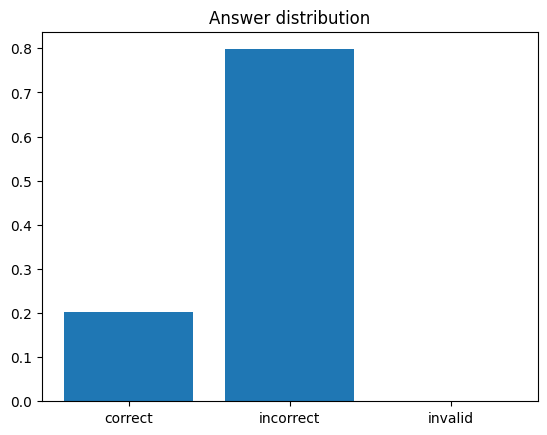

In [ ]:
plot_answer_stats(model, val_set, prompt_strategy, verbose=False, pad_soft=True)

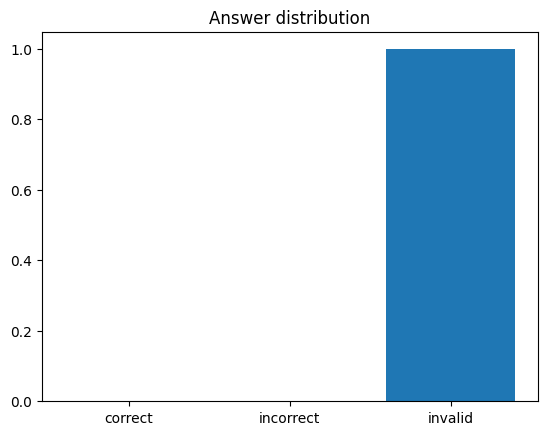

In [ ]:
plot_answer_stats(hard_embedding_model, val_set, prompt_strategies['qa_instruction'], pad_soft=False, verbose=False)

In [ ]:
model_soft_qa = model

# Pluralize task

As you can see above, the soft embedding model does not perform very well on this task. We'll show how soft prompting does better on a second, very simple task - pluralizing a word.

The dataset we use was found here, and consists of a list of English nouns: https://www.kaggle.com/datasets/leite0407/list-of-nouns?select=nounlist.csv.
For simplicity, we will only consider words where the output is a single token (to avoid needing to deal with sequential generation for evaluation), but you could adapt the code to generate arbitrarily long outputs.

If you get memory errors when running this part, re-run the notebook while skipping loading the previous dataset and soft model.


!! If you run into an error during training complaining about batch size dimensions, this is an edge-case issue where we get errors when the last batch in an epoch length 1. You can fix this by removing the item in the train set. !!

In [ ]:
!curl -L -o list-of-nouns.zip https://www.kaggle.com/api/v1/datasets/download/leite0407/list-of-nouns

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22376  100 22376    0     0  53168      0 --:--:-- --:--:-- --:--:-- 53168


In [ ]:
!unzip list-of-nouns.zip

Archive:  list-of-nouns.zip
  inflating: nounlist.csv            


We'll create targets for this dataset using the inflect library, which is a Python library for inflecting English words. You can read more about it here: https://pypi.org/project/inflect/. This library can convert word to plural forms (though it is not 100% reliable).

In [ ]:
# Set of words with unusual plurals
noun_test = ['foot', 'man', 'person', 'self', 'wife', 'wolf', 'woman']

engine = inflect.engine()

# Load new noun_list dataset from csv file
with open('nounlist.csv', 'r') as f:
    noun_list = f.read().splitlines()
    noun_list = [i.strip() for i in noun_list]
random.seed(0)
# shuffle the noun list
random.shuffle(noun_list)
print(noun_list)
# Remove all list items which are in the nouns list (our test set)
noun_list = [i for i in noun_list if i not in noun_test]
# Remove the last 10% for validation
noun_train = noun_list[:-int(len(noun_list)*0.1)]
noun_val = noun_list[-int(len(noun_list)*0.1):]

# Plural task
def format_dataset(noun_list):
    dataset = []
    for noun in noun_list:
        plural = engine.plural(noun)
        dataset.append({'answerKey': plural, 'input': noun})
    return dataset


noun_train = format_dataset(noun_train)
noun_val = format_dataset(noun_val)
noun_test = format_dataset(noun_test)


# Only include nouns where the plural is a single token
noun_train = [i for i in noun_train if len(tokenizer(i['answerKey'])['input_ids']) == 1]
noun_val = [i for i in noun_val if len(tokenizer(i['answerKey'])['input_ids']) == 1]
noun_test = [i for i in noun_test if len(tokenizer(i['answerKey'])['input_ids']) == 1]

# Print the first 10 items in the dataset
print([point['input'] for point in noun_train[:10]])
print([point['answerKey'] for point in noun_train[:10]])

print(f'Lengths: train: {len(noun_train)}, val: {len(noun_val)}, test: {len(noun_test)}')

['pathogenesis', 'pitcher', 'occasion', 'reactant', 'laugh', 'rehospitalization', 'abbreviation', 'probability', 'comradeship', 'handsaw', 'mineshaft', 'surfboard', 'lender', 'formamide', 'obsidian', 'towel', 'soap', 'mattress', 'attention', 'doorway', 'demur', 'haste', 'ukulele', 'blackboard', 'facet', 'clause', 'enrollment', 'visitor', 'revitalisation', 'feng', 'con', 'program', 'wake', 'grass', 'weekend', 'script', 'purr', 'darkness', 'hut', 'sucker', 'platinum', 'west', 'cricketer', 'swallow', 'hop', 'obesity', 'hiring', 'typeface', 'temptation', 'protection', 'mechanism', 'carload', 'burrow', 'cabbage', 'thread', 'hatbox', 'wick', 'mailbox', 'catalyst', 'legal', 'tramp', 'upstairs', 'graft', 'utilisation', 'march', 'zoot-suit', 'yawl', 'candle', 'tintype', 'cultivator', 'minimalism', 'arcade', 'almighty', 'scarf', 'segment', 'pet', 'shortwave', 'prosecution', 'reminder', 'mop', 'traditionalism', 'chop', 'grandparent', 'caviar', 'cruelty', 'pioneer', 'prune', 'slave', 'flute', 'eva

Compare hard prompting with soft prompting on this task, then answer the analysis questions in the written part of this homework. You should get over 60% correct on the val set with soft prompting.

In [ ]:
def basic_format(point):
    if isinstance(point, dict):
        point = point['input']
    return f"The plural of {point} is"

examples = ['pasta', 'sweater', 'wave', 'mouse', 'attorney', 'bottle', 'phone', 'grass', 'evening', 'candy', 'flower', 'planet', 'architect', 'washer',
            'keyhole', 'economy', 'grace', 'finance', 'midnight', 'cushion', 'plateau', 'mouse', 'chord', 'cactus', 'swap', 'tremor', 'criterion', 'sink', 'bandana', 'trade'
            ]

def make_few_shot(i):
    def few_shot(point):
        prompt = ''
        for j in range(i):
            prompt += basic_format(examples[j]) + ' ' + engine.plural(examples[j]) + '.\n'
        prompt += basic_format(point)
        return prompt
    return few_shot

In [ ]:
model_pluralize = initialize_soft_model()
train_model(model_pluralize, noun_train, noun_val, basic_format, batch_size=8, epochs=40)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 0, Item 0, loss: 8.7362060546875
Epoch 0, Item 200, loss: 8.222498893737793
decoding  a a a a a a a is
--------------------
Epoch 0, Validation loss: 7.030351737449909
Epoch 1, Item 0, loss: 7.263357639312744
Epoch 1, Item 200, loss: 6.450688362121582
decoding  a is is a work a a is
--------------------
Epoch 1, Validation loss: 6.239261462770659
Epoch 2, Item 0, loss: 6.260743141174316
Epoch 2, Item 200, loss: 6.015690803527832
decoding  a is is service work is a is
--------------------
Epoch 2, Validation loss: 5.703594635272848
Epoch 3, Item 0, loss: 5.587852954864502
Epoch 3, Item 200, loss: 5.775708198547363
decoding  a is is service work is a inch
--------------------
Epoch 3, Validation loss: 5.344602765708134
Epoch 4, Item 0, loss: 5.197272300720215
Epoch 4, Item 200, loss: 5.6266021728515625
decoding  a is is service work step a inch
--------------------
Epoch 4, Validation loss: 5.059251226227859
Epoch 5, Item 0, loss: 4.9706339836120605
Epoch 5, Item 200, loss: 5.51958

In [ ]:
# Save the model to a pickle file (If your runtime crashes, you can load the model from this file)
with open('soft_embeddings_model_pluralize.pkl', 'wb') as f:
    pkl.dump(model, f)

NameError: name 'model' is not defined

Prompt: The plural of skirt is, output: |skirts|, answerkey |skirts|
Prompt: The plural of ink is, output: |ink|, answerkey |inks|
Prompt: The plural of fish is, output: |fishes|, answerkey |fish|
Prompt: The plural of service is, output: |services|, answerkey |services|
Prompt: The plural of work is, output: |works|, answerkey |works|
Prompt: The plural of step is, output: |steps|, answerkey |steps|
Prompt: The plural of thanks is, output: |thanks|, answerkey |thank|
Prompt: The plural of inch is, output: |inches|, answerkey |inches|
Prompt: The plural of rice is, output: |rice|, answerkey |rices|
Prompt: The plural of tic is, output: |t|, answerkey |tics|
Prompt: The plural of hops is, output: |hops|, answerkey |hop|
Prompt: The plural of gun is, output: |guns|, answerkey |guns|
Prompt: The plural of series is, output: |series|, answerkey |series|
Prompt: The plural of stair is, output: |stair|, answerkey |stairs|
Prompt: The plural of thing is, output: |things|, answerkey |things|
P

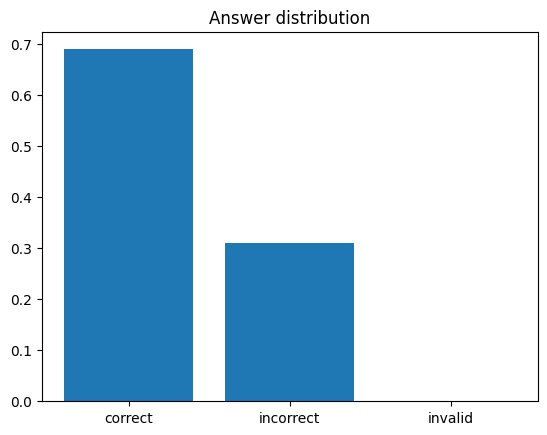

Prompt: The plural of foot is, output: |feet|, answerkey |feet|
Prompt: The plural of man is, output: |men|, answerkey |men|
Prompt: The plural of person is, output: |persons|, answerkey |people|
Prompt: The plural of self is, output: |self|, answerkey |selves|
Prompt: The plural of wife is, output: |wives|, answerkey |wives|
Prompt: The plural of wolf is, output: |wolves|, answerkey |wolves|
Prompt: The plural of woman is, output: |women|, answerkey |women|


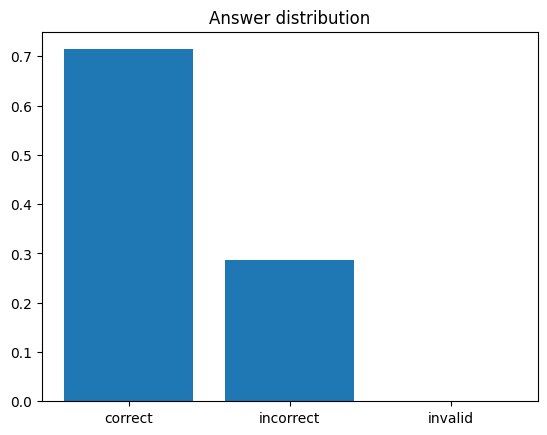

In [ ]:
plot_answer_stats(model_pluralize, noun_val, basic_format, verbose=True, pad_soft=True)
plot_answer_stats(model_pluralize, noun_test, basic_format, verbose=True, pad_soft=True)

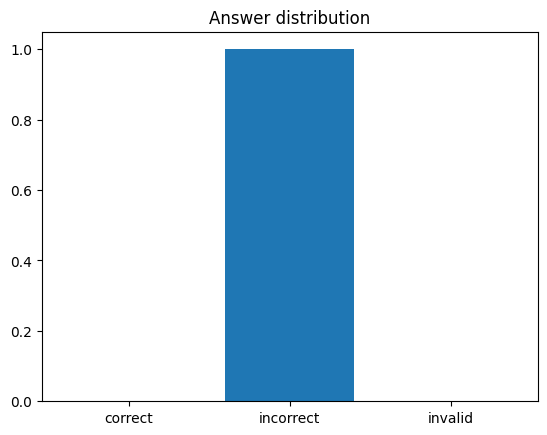

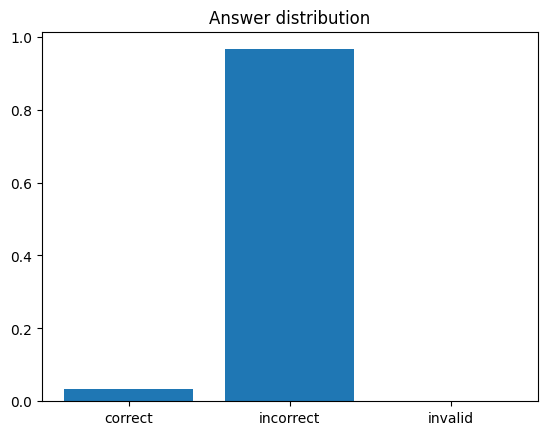

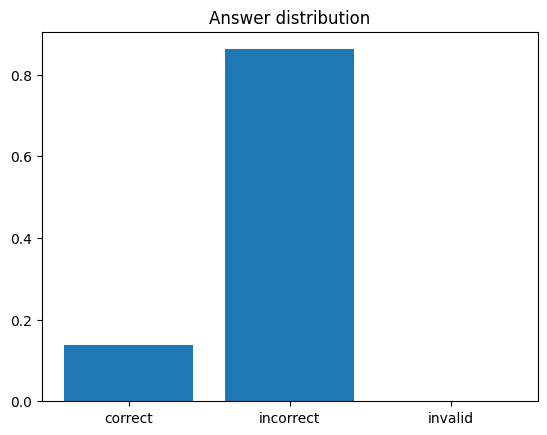

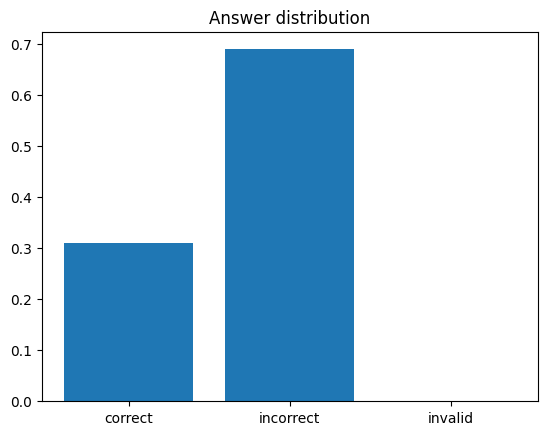

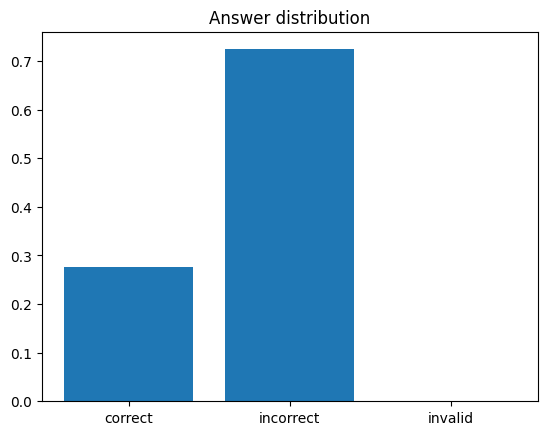

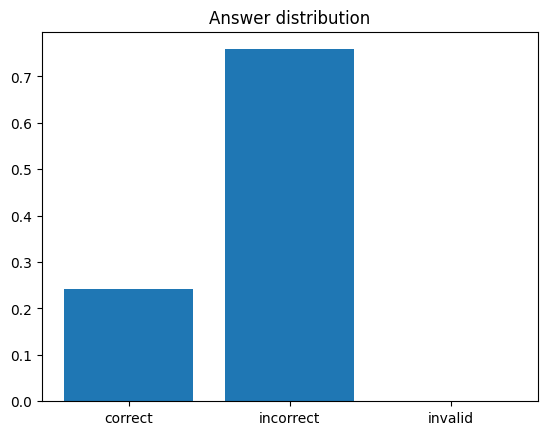

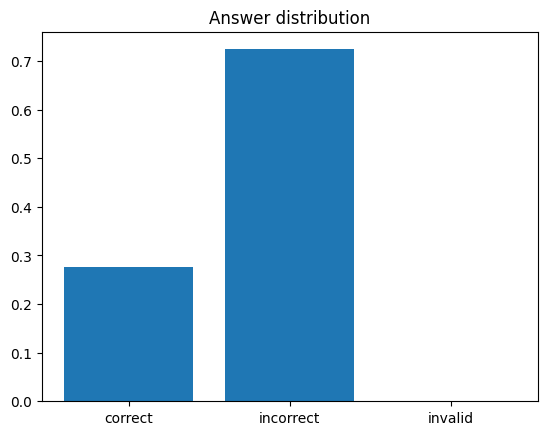

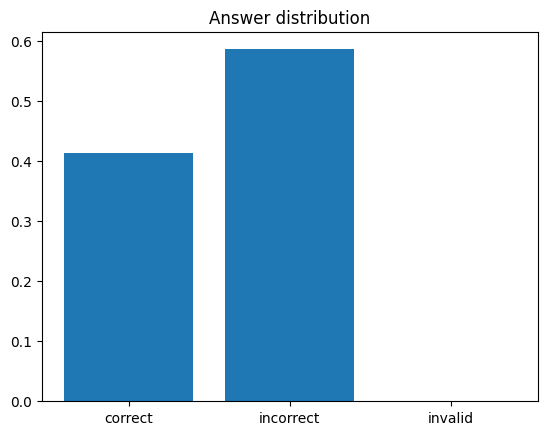

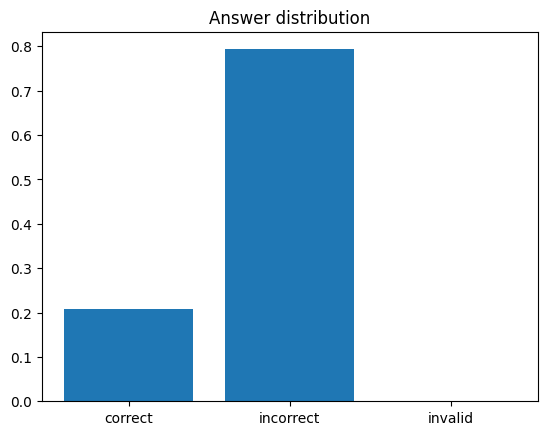

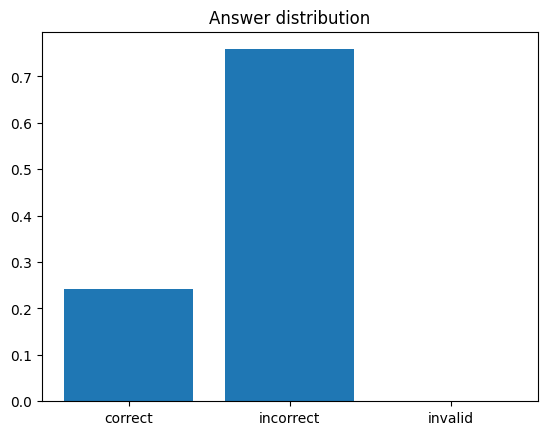

In [ ]:
# Plot results with hard prompts of various lengths
for num_shots in range(10):
    plot_answer_stats(hard_embedding_model, noun_val, make_few_shot(num_shots), verbose=False, pad_soft=True)